In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os, sys
import argparse
import torch

from Code.Utils import from_pickle
from Code.models import cartpole
from Code.integrate_models import implicit_integration_DEL, integrate_ODE
from Code.symo import SyMo_RT
from Code.NN import LODE_RT, NODE_RT
from Code.models import get_field, cartpole

THIS_DIR = os.getcwd()

In [3]:
DPI = 100
FORMAT = 'png'
LINE_SEGMENTS = 10
ARROW_SCALE = 60
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
save_dir = "Experiments_cartpole/noise"

def get_args():
    return {'fig_dir': './figures/cartpole',
            'gpu': 2,
            'pred_tol': 1e-5 ,
            'pred_maxiter': 10}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

args = ObjectView(get_args())

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')


In [35]:

def load_stats(nn, models):
    #loads the stats of all models
    train_loss = []
    test_loss= []
    int_loss = []
    int_std = []
    E_loss = []
    E_std = []
    H_loss = []
    H_std = []
    for model in models:
        path = '{}/{}/{}{}-p-32x32_sigma_{}-stats.pkl'.format(THIS_DIR, save_dir, "cartpole-", nn, model)
        stats = from_pickle(path)
        if 'SyMo' in nn:
            train_loss.append(stats['train_loss_poses'])
            test_loss.append(stats['test_loss_poses'])
        else:
            train_loss.append(stats['train_loss_poses'])
            test_loss.append(stats['test_loss_poses'])
        
        int_loss.append(stats['int_loss_poses'])
        int_std.append(stats['int_std'])
        E_loss.append(stats['E_loss'])
        E_std.append(stats['E_std'])
        if nn != 'NODE-rk4' and nn != "NODE-midpoint":
            H_loss.append(stats['H_loss'])
            H_std.append(stats['H_std'])
    if nn != 'NODE-rk4' and nn != "NODE-midpoint":
        return train_loss, test_loss, int_loss, int_std, E_loss, E_std, H_loss, H_std
    else:
        return train_loss, test_loss, int_loss, int_std, E_loss, E_std

def load_stats_noiseless(nn, models):
    #loads the stats of all models
    train_loss = []
    test_loss= []
    int_loss = []
    int_std = []
    E_loss = []
    E_std = []
    H_loss = []
    H_std = []
    for model in models:
        path = '{}/{}/{}{}-p-{}-stats.pkl'.format(THIS_DIR, "Experiments_cartpole/h=0.05", "cartpole-", nn, model)
        stats = from_pickle(path)
        if 'SyMo' in nn:
            train_loss.append(stats['train_loss_poses'])
            test_loss.append(stats['test_loss_poses'])
        else:
            train_loss.append(stats['train_loss_poses'])
            test_loss.append(stats['test_loss_poses'])
        
        int_loss.append(stats['int_loss_poses'])
        int_std.append(stats['int_std'])
        E_loss.append(stats['E_loss'])
        E_std.append(stats['E_std'])
        if nn != 'NODE-rk4' and nn != "NODE-midpoint":
            H_loss.append(stats['H_loss'])
            H_std.append(stats['H_std'])
    if nn != 'NODE-rk4' and nn != "NODE-midpoint":
        return train_loss, test_loss, int_loss, int_std, E_loss, E_std, H_loss, H_std
    else:
        return train_loss, test_loss, int_loss, int_std, E_loss, E_std
models=["32x32"]
#Load E2E-SyMo models
train_loss_N_SYMO_noiseless, test_loss_N_SYMO_noiseless, int_loss_N_SYMO_noiseless, int_std_N_SYMO, E_loss_N_SYMO, E_std_N_SYMO, H_loss_N_SYMO, H_std_N_SYMO = load_stats_noiseless('N-SyMo', models)
# Load SyMo models
train_loss_SYMO_noiseless, test_loss_SYMO_noiseless, int_loss_SYMO_noiseless, int_std_SYMO, E_loss_SYMO, E_std_SYMO, H_loss_SYMO, H_std_SYMO = load_stats_noiseless('SyMo', models)
#Load LODE_RK4 models
train_loss_LODE_RK4_noiseless, test_loss_LODE_RK4_noiseless, int_loss_LODE_RK4_noiseless, int_std_LODE_RK4, E_loss_LODE_RK4, E_std_LODE_RK4, H_loss_LODE_RK4, H_std_LODE_RK4 = load_stats_noiseless('L-NODE-rk4', models)
#Load LODE_RK2 models
train_loss_LODE_RK2_noiseless, test_loss_LODE_RK2_noiseless, int_loss_LODE_RK2_noiseless, int_std_LODE_RK2, E_loss_LODE_RK2, E_std_LODE_RK2, H_loss_LODE_RK2, H_std_LODE_RK2 = load_stats_noiseless('L-NODE-midpoint', models)
#Load NODE_RK4 models
train_loss_NODE_RK4_noiseless, test_loss_NODE_RK4_noiseless, int_loss_NODE_RK4_noiseless, int_std_NODE_RK4, E_loss_NODE_RK4, E_std_NODE_RK4 = load_stats_noiseless('NODE-rk4', models)
#Load NODE_RK2 models
train_loss_NODE_RK2_noiseless, test_loss_NODE_RK2_noiseless, int_loss_NODE_RK2_noiseless, int_std_NODE_RK2, E_loss_NODE_RK2, E_std_NODE_RK2 = load_stats_noiseless('NODE-midpoint', models)


models = [0.0001, 0.0005, 0.001, 0.005, 0.01]
#Load E2E-SyMo models
train_loss_N_SYMO, test_loss_N_SYMO, int_loss_N_SYMO, int_std_N_SYMO, E_loss_N_SYMO, E_std_N_SYMO, H_loss_N_SYMO, H_std_N_SYMO = load_stats('N-SyMo', models)
# Load SyMo models
train_loss_SYMO, test_loss_SYMO, int_loss_SYMO, int_std_SYMO, E_loss_SYMO, E_std_SYMO, H_loss_SYMO, H_std_SYMO = load_stats('SyMo', models)
#Load LODE_RK4 models
train_loss_LODE_RK4, test_loss_LODE_RK4, int_loss_LODE_RK4, int_std_LODE_RK4, E_loss_LODE_RK4, E_std_LODE_RK4, H_loss_LODE_RK4, H_std_LODE_RK4 = load_stats('L-NODE-rk4', models)
#Load LODE_RK2 models
train_loss_LODE_RK2, test_loss_LODE_RK2, int_loss_LODE_RK2, int_std_LODE_RK2, E_loss_LODE_RK2, E_std_LODE_RK2, H_loss_LODE_RK2, H_std_LODE_RK2 = load_stats('L-NODE-midpoint', models)
#Load NODE_RK4 models
train_loss_NODE_RK4, test_loss_NODE_RK4, int_loss_NODE_RK4, int_std_NODE_RK4, E_loss_NODE_RK4, E_std_NODE_RK4 = load_stats('NODE-rk4', models)
#Load NODE_RK2 models
train_loss_NODE_RK2, test_loss_NODE_RK2, int_loss_NODE_RK2, int_std_NODE_RK2, E_loss_NODE_RK2, E_std_NODE_RK2 = load_stats('NODE-midpoint', models)

train_loss_N_SYMO = [*train_loss_N_SYMO_noiseless, *train_loss_N_SYMO]
train_loss_SYMO = [*train_loss_SYMO_noiseless, *train_loss_SYMO]
train_loss_LODE_RK2 = [*train_loss_LODE_RK2_noiseless, *train_loss_LODE_RK2]
train_loss_LODE_RK4 = [*train_loss_LODE_RK4_noiseless, *train_loss_LODE_RK4]
train_loss_NODE_RK2 = [*train_loss_NODE_RK2_noiseless, *train_loss_NODE_RK2]
train_loss_NODE_RK4 = [*train_loss_NODE_RK4_noiseless, *train_loss_NODE_RK4]

test_loss_N_SYMO = [*test_loss_N_SYMO_noiseless, *test_loss_N_SYMO]
test_loss_SYMO = [*test_loss_SYMO_noiseless, *test_loss_SYMO]
test_loss_LODE_RK2 = [*test_loss_LODE_RK2_noiseless, *test_loss_LODE_RK2]
test_loss_LODE_RK4 = [*test_loss_LODE_RK4_noiseless, *test_loss_LODE_RK4]
test_loss_NODE_RK2 = [*test_loss_NODE_RK2_noiseless, *test_loss_NODE_RK2]
test_loss_NODE_RK4 = [*test_loss_NODE_RK4_noiseless, *test_loss_NODE_RK4]

int_loss_N_SYMO = [*int_loss_N_SYMO_noiseless, *int_loss_N_SYMO]
int_loss_SYMO = [*int_loss_SYMO_noiseless, *int_loss_SYMO]
int_loss_LODE_RK2 = [*int_loss_LODE_RK2_noiseless, *int_loss_LODE_RK2]
int_loss_LODE_RK4 = [*int_loss_LODE_RK4_noiseless, *int_loss_LODE_RK4]
int_loss_NODE_RK2 = [*int_loss_NODE_RK2_noiseless, *int_loss_NODE_RK2]
int_loss_NODE_RK4 = [*int_loss_NODE_RK4_noiseless, *int_loss_NODE_RK4]

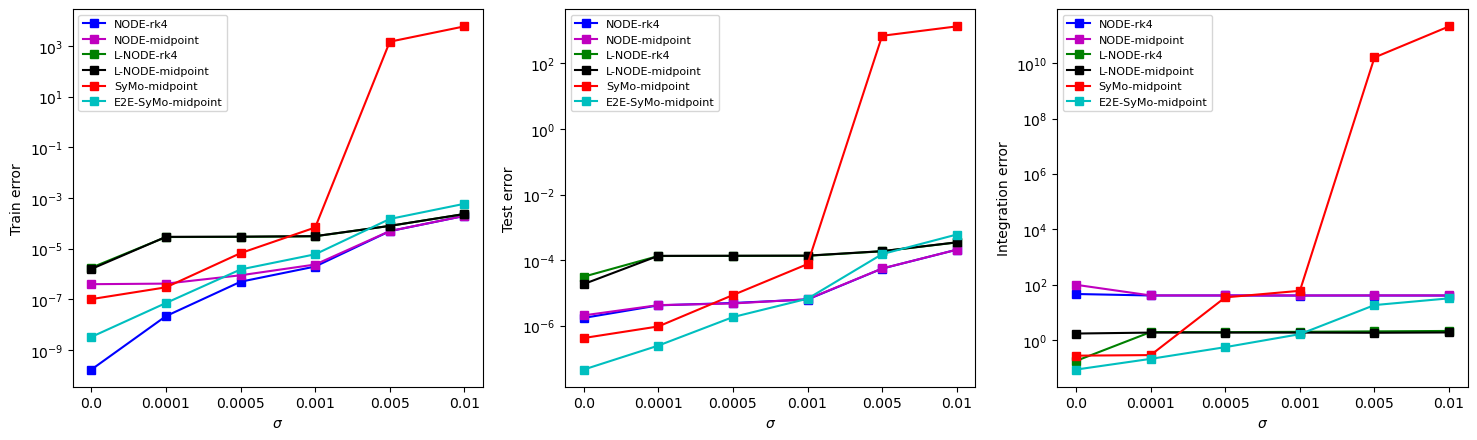

In [37]:
x_axis = np.array([0, 0.0001, 0.0005, 0.001, 0.005, 0.01])

fig = plt.figure(figsize=(18, 5), dpi=DPI)
ax1=plt.subplot(1, 3, 1)
plt.plot(x_axis.astype('str'), train_loss_NODE_RK4, 'bs-', label='NODE-rk4')
plt.plot(x_axis.astype('str'), train_loss_NODE_RK2, 'ms-', label='NODE-midpoint')
plt.plot(x_axis.astype('str'), train_loss_LODE_RK4, 'gs-', label= 'L-NODE-rk4')
plt.plot(x_axis.astype('str'), train_loss_LODE_RK2, 'ks-', label='L-NODE-midpoint')
plt.plot(x_axis.astype('str'), train_loss_SYMO, 'rs-', label='SyMo-midpoint')
plt.plot(x_axis.astype('str'), train_loss_N_SYMO, 'cs-', label  = 'E2E-SyMo-midpoint')

# plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=8)
plt.ylabel('Train error')
plt.xlabel('$\sigma$')

plt.subplot(1, 3, 2)
plt.plot(x_axis.astype('str'), test_loss_NODE_RK4, 'bs-', label='NODE-rk4')
plt.plot(x_axis.astype('str'), test_loss_NODE_RK2, 'ms-', label='NODE-midpoint')
plt.plot(x_axis.astype('str'), test_loss_LODE_RK4, 'gs-', label= 'L-NODE-rk4')
plt.plot(x_axis.astype('str'), test_loss_LODE_RK2, 'ks-', label='L-NODE-midpoint')
plt.plot(x_axis.astype('str'), test_loss_SYMO, 'rs-', label='SyMo-midpoint')
plt.plot(x_axis.astype('str'), test_loss_N_SYMO, 'cs-', label  = 'E2E-SyMo-midpoint')
# plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=8)
plt.xlabel('$\sigma$')
plt.ylabel('Test error')

plt.subplot(1, 3, 3)
plt.plot(x_axis.astype('str'), int_loss_NODE_RK4, 'bs-', label='NODE-rk4')
plt.plot(x_axis.astype('str'), int_loss_NODE_RK2, 'ms-', label='NODE-midpoint')
plt.plot(x_axis.astype('str'), int_loss_LODE_RK4, 'gs-', label= 'L-NODE-rk4')
plt.plot(x_axis.astype('str'), int_loss_LODE_RK2, 'ks-', label='L-NODE-midpoint')
plt.plot(x_axis.astype('str'), int_loss_SYMO, 'rs-', label='SyMo-midpoint')
plt.plot(x_axis.astype('str'), int_loss_N_SYMO, 'cs-', label  = 'E2E-SyMo-midpoint')
# plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=8)
plt.xlabel('$\sigma$')
plt.ylabel('Integration error')

fig.savefig('{}/fig-train-pred-loss_noise_cartpole.{}'.format(args.fig_dir, FORMAT))

